# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-preparation-and-cleaning" data-toc-modified-id="Data-preparation-and-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation and cleaning</a></div><div class="lev1 toc-item"><a href="#Comparison-pre-and-post-normalization" data-toc-modified-id="Comparison-pre-and-post-normalization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Comparison pre and post normalization</a></div><div class="lev1 toc-item"><a href="#PCA-analysis" data-toc-modified-id="PCA-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PCA analysis</a></div>

In [5]:
library(tidyverse, quiet=T)

library(caret, quiet=T)

In [23]:
dat0 <- read.csv("../training_ultrasound.csv")
count = dplyr::count
n = dplyr::n

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID) 
        )%>%
        filter(AGEDAYS<0)

head(dat.raw)
cat("Total number of unique entries per column:\n")
dat.raw %>% summarise_each(funs(n_distinct(.)))

cat("Distribution of measurements by subject")
dat.raw %>% count(SUBJID) %>% mutate(tot=n) %>% count(tot) %>% t

dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1)

STUDYID,SUBJID,SEXN,SEX,GAGEBRTH,BIRTHWT,BIRTHLEN,BIRTHHC,DELIVERY,PARITY,⋯,FLAZ,BHC_Z,BLEN_Z,BWT_Z,BWT_40,BLEN_40,BHC_40,LOG10.FWT.GM,WTKG.estimate,Study
1,1002,2,Female,276,3540,50.3,NA,Category 2.0,1,⋯,2.1426457,NA,0.8916001,0.8604704,3.614882,50.61003,NA,3.486183,3.0632504,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,1.6165714,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.233630,1.7124993,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,1.4955694,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.233630,1.7124993,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,1.1068995,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.419602,2.6278574,Study 1
1,1003,1,Male,280,3100,50.3,NA,Category 2.0,1,⋯,0.8767282,NA,0.2352980,-0.7255638,3.100000,50.30000,NA,3.419602,2.6278574,Study 1
1,1005,1,Male,269,2750,49.3,NA,Category 2.0,1,⋯,-0.6436616,NA,0.2390059,-1.0127406,2.988224,50.30595,NA,2.777395,0.5989562,Study 1


Total number of unique entries per column:


STUDYID,SUBJID,SEXN,SEX,GAGEBRTH,BIRTHWT,BIRTHLEN,BIRTHHC,DELIVERY,PARITY,⋯,FLAZ,BHC_Z,BLEN_Z,BWT_Z,BWT_40,BLEN_40,BHC_40,LOG10.FWT.GM,WTKG.estimate,Study
2,2491,2,2,60,226,92,40,7,7,⋯,1656,167,708,1947,1906,701,159,6777,6777,2


Distribution of measurements by subject

tot,1,2,3,4,5,6,7,8,9,10
nn,245,538,717,708,81,126,19,41,10,6


In [7]:
dat %>% select(AGEDAYS, GAGEDAYS)%>% head

Adding missing grouping variables: `SUBJID`


SUBJID,AGEDAYS,GAGEDAYS
1003,-57,223
1003,-56,224
1003,-17,263
1003,-14,266
1005,-100,169
1005,-47,222


# Data preparation and cleaning
We use the preProcess function from caret to prepare the data.

Procedure:

- remove all samples with only one measurement
- These attributes seem to be related to size: 
    - ABCIRCM (Abdominal Circumference)
    - HCIRCM (Head Circumference)
    - BPDCM (Biparietal diameter)
    - FEMURCM (Femur Length)
- the preProcess function will:
    - center and scale the data to make it normally distributed. 
    - do a PCA, to get a sense of whether these variables could be reduced to fewer dimensions
        - ideally we would like to reduce it to one variable, for the trajectory clustering
    - do imputation using knn
    
    

In [8]:
# clean data, remove samples with only one observation
dat.covars = dat %>% ungroup %>%
    select(ABCIRCM, HCIRCM, BPDCM, FEMURCM)

dat.preproc = dat.covars  %>%
    mutate_each(funs(as.numeric(.))) %>%
    preProcess(., method=c("center", "scale", "knnImpute", "pca"))

dat.preproc.nopca = dat.covars  %>%
    mutate_each(funs(as.numeric(.))) %>%
    preProcess(., method=c("center", "scale", "knnImpute" ))
#    preProcess(., method=c("center", "scale", "knnImpute", "YeoJohnson", "pca"))

dat.preproc$data %>% head


ABCIRCM,HCIRCM,BPDCM,FEMURCM
0.1748652,0.4696978,0.4973090,0.53587748
0.1748652,0.4696978,0.4973090,0.53587748
0.7843833,0.7376261,0.9603249,1.07530013
0.7843833,0.7376261,0.9603249,1.07530013
-0.7394120,-0.6169007,-0.6859539,-0.78271123
0.1881156,0.2761939,0.3429703,0.05639068


In [9]:
dat.preproc$mean

ABCIRCM    HCIRCM     BPDCM   FEMURCM 
24.280302 26.044470  7.233342  5.405915

In [10]:
dat.preproc$rotation

,PC1,PC2
ABCIRCM,-0.4988286,-0.7214166
HCIRCM,-0.5010295,0.3781719
BPDCM,-0.5001753,0.5434810
FEMURCM,-0.4999642,-0.2029102


Let's see how the predictor can impute the values from the originary frame:

In [11]:
dat.predicted = predict(
        dat.preproc %>% as.matrix,
        dat.covars 
        )

dat.predicted %>% head
dat.covars %>% head

ABCIRCM,HCIRCM,BPDCM,FEMURCM
25.6,29.2,8.2,6.3
25.6,29.2,8.2,6.3
30.2,31.0,9.1,7.2
30.2,31.0,9.1,7.2
18.7,21.9,5.9,4.1
25.7,27.9,7.9,5.5


ABCIRCM,HCIRCM,BPDCM,FEMURCM
25.6,29.2,8.2,6.3
25.6,29.2,8.2,6.3
30.2,31.0,9.1,7.2
30.2,31.0,9.1,7.2
18.7,21.9,5.9,4.1
25.7,27.9,7.9,5.5


In [12]:
dat.preproc$rotation


,PC1,PC2
ABCIRCM,-0.4988286,-0.7214166
HCIRCM,-0.5010295,0.3781719
BPDCM,-0.5001753,0.5434810
FEMURCM,-0.4999642,-0.2029102


# Comparison pre and post normalization


Warning message:
“Removed 276 rows containing non-finite values (stat_density).”

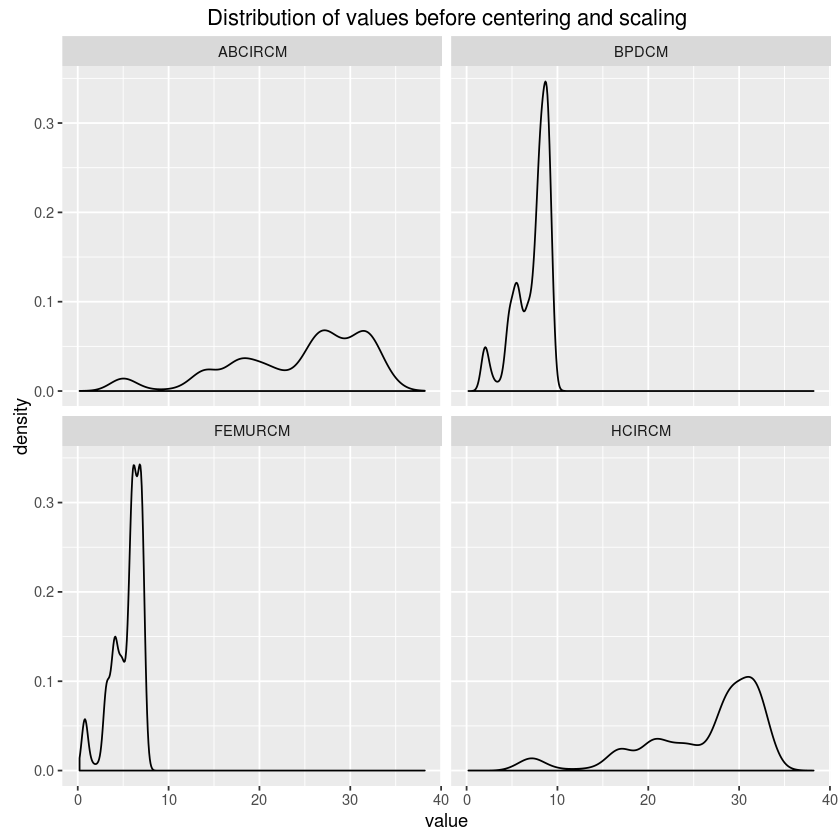

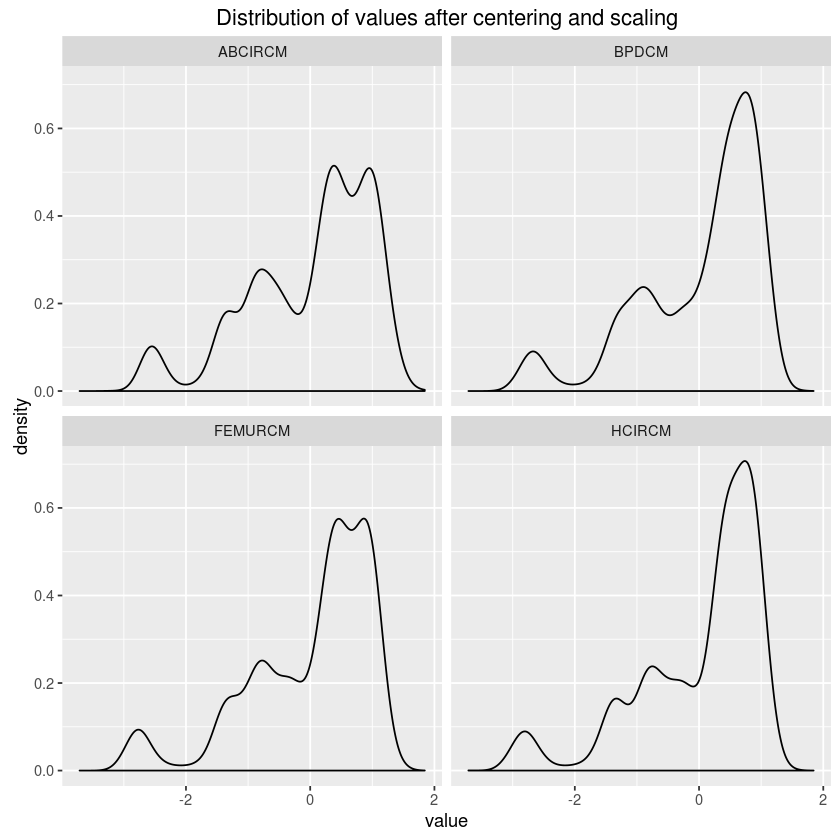

In [13]:

dat.covars %>%  gather(feature, value) %>% 
    ggplot(aes(x=value)) +
        facet_wrap(~feature) +
        geom_density() +
        ggtitle("Distribution of values before centering and scaling")


dat.preproc$data %>% gather(feature, value) %>% mutate(label="post-normalization") %>%
    ggplot(aes(x=value)) +
        facet_wrap(~feature) +
        geom_density() +
        ggtitle("Distribution of values after centering and scaling")



# PCA analysis

I still haven't discovered how to get a biplot from the output of preProcess, so I'll recalculate the PCA manually.

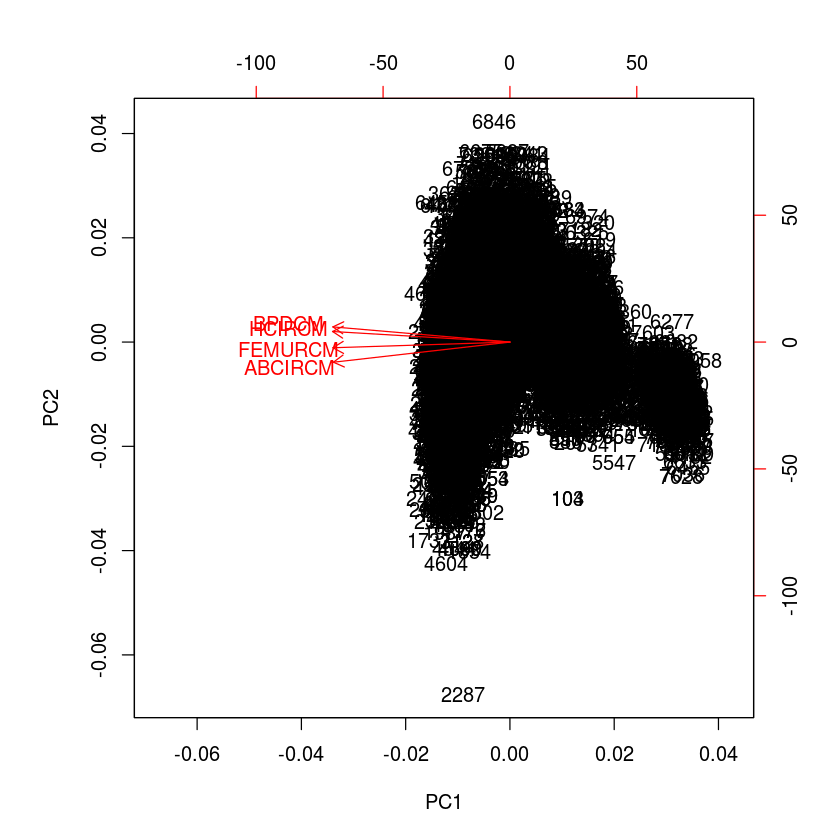

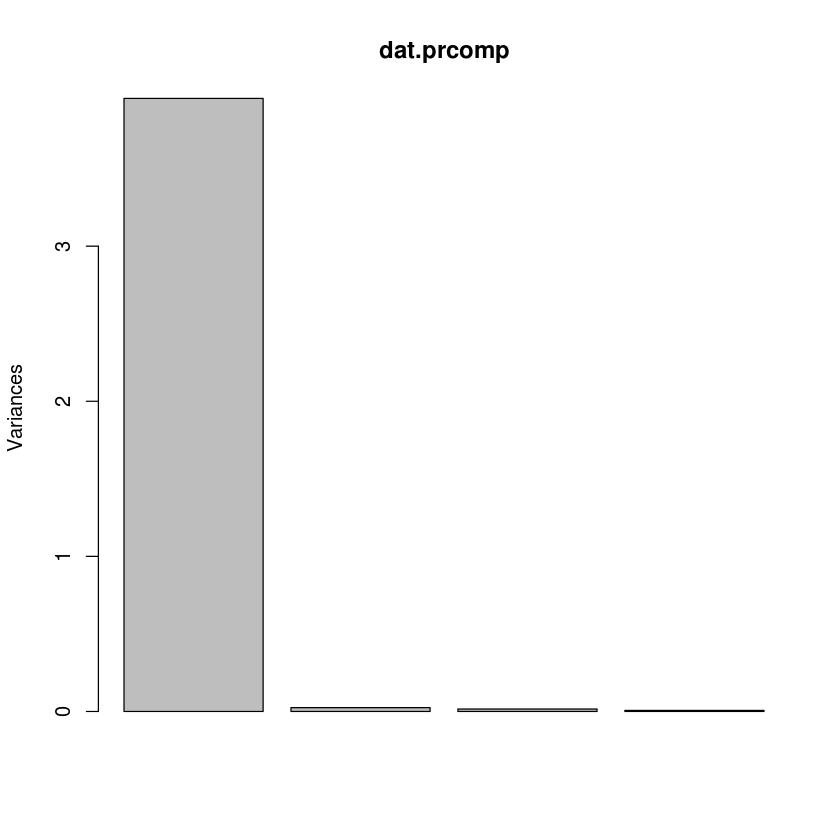

In [22]:
dat.prcomp = dat %>% ungroup %>% 
    select(ABCIRCM, HCIRCM, BPDCM, FEMURCM)  %>%filter(complete.cases(.)) %>%
     prcomp(., center=T, scale.=T)
biplot(dat.prcomp)
plot(dat.prcomp)

In [26]:
dat %>% ungroup %>% count(PARITY, STUDYID)

PARITY,STUDYID,n
0,2,979
1,1,5262
1,2,724
2,1,341
2,2,313
3,2,103
4,2,17
7,2,3
NA,1,41
NA,2,48


In [30]:
dat %>% ungroup %>% count(PARITY, GRAVIDA, STUDYID)

PARITY,GRAVIDA,STUDYID,n
0,1,2,689
0,2,2,208
0,3,2,60
0,4,2,12
0,5,2,3
0,6,2,7
1,1,1,3871
1,2,1,1083
1,2,2,432
1,3,1,238


In [15]:

9 * 40

[1] 360